In [25]:
using ITensors
using PyCall
using Plots
using Random, Distributions
using DelimitedFiles
using StatsBase

# Creating Number States in ITensor

In [4]:
sites = siteinds("Qudit", 10; dim=10);

In [6]:
mps = randomMPS(sites; linkdims=4)

MPS
[1] ((dim=10|id=576|"Qudit,Site,n=1"), (dim=4|id=107|"Link,l=1"))
[2] ((dim=4|id=107|"Link,l=1"), (dim=10|id=903|"Qudit,Site,n=2"), (dim=4|id=708|"Link,l=2"))
[3] ((dim=4|id=708|"Link,l=2"), (dim=10|id=553|"Qudit,Site,n=3"), (dim=4|id=102|"Link,l=3"))
[4] ((dim=4|id=102|"Link,l=3"), (dim=10|id=406|"Qudit,Site,n=4"), (dim=4|id=89|"Link,l=4"))
[5] ((dim=4|id=89|"Link,l=4"), (dim=10|id=846|"Qudit,Site,n=5"), (dim=4|id=699|"Link,l=5"))
[6] ((dim=4|id=699|"Link,l=5"), (dim=10|id=122|"Qudit,Site,n=6"), (dim=4|id=718|"Link,l=6"))
[7] ((dim=4|id=718|"Link,l=6"), (dim=10|id=64|"Qudit,Site,n=7"), (dim=4|id=823|"Link,l=7"))
[8] ((dim=4|id=823|"Link,l=7"), (dim=10|id=253|"Qudit,Site,n=8"), (dim=4|id=34|"Link,l=8"))
[9] ((dim=4|id=34|"Link,l=8"), (dim=10|id=35|"Qudit,Site,n=9"), (dim=4|id=957|"Link,l=9"))
[10] ((dim=4|id=957|"Link,l=9"), (dim=10|id=267|"Qudit,Site,n=10"))


In [7]:
mps2 = randomMPS(sites; linkdims=4)

MPS
[1] ((dim=10|id=576|"Qudit,Site,n=1"), (dim=4|id=255|"Link,l=1"))
[2] ((dim=4|id=255|"Link,l=1"), (dim=10|id=903|"Qudit,Site,n=2"), (dim=4|id=773|"Link,l=2"))
[3] ((dim=4|id=773|"Link,l=2"), (dim=10|id=553|"Qudit,Site,n=3"), (dim=4|id=349|"Link,l=3"))
[4] ((dim=4|id=349|"Link,l=3"), (dim=10|id=406|"Qudit,Site,n=4"), (dim=4|id=369|"Link,l=4"))
[5] ((dim=4|id=369|"Link,l=4"), (dim=10|id=846|"Qudit,Site,n=5"), (dim=4|id=543|"Link,l=5"))
[6] ((dim=4|id=543|"Link,l=5"), (dim=10|id=122|"Qudit,Site,n=6"), (dim=4|id=929|"Link,l=6"))
[7] ((dim=4|id=929|"Link,l=6"), (dim=10|id=64|"Qudit,Site,n=7"), (dim=4|id=111|"Link,l=7"))
[8] ((dim=4|id=111|"Link,l=7"), (dim=10|id=253|"Qudit,Site,n=8"), (dim=4|id=610|"Link,l=8"))
[9] ((dim=4|id=610|"Link,l=8"), (dim=10|id=35|"Qudit,Site,n=9"), (dim=4|id=256|"Link,l=9"))
[10] ((dim=4|id=256|"Link,l=9"), (dim=10|id=267|"Qudit,Site,n=10"))


# Try PyCall with SaX

In [8]:
pyts = pyimport("pyts.approximation")
X = randn(3, 100);

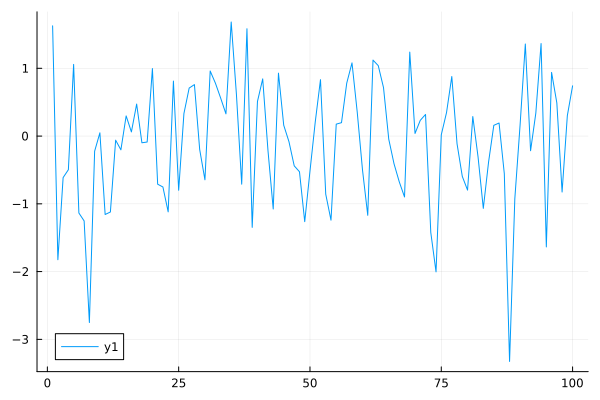

In [9]:
plot(X[1, :])

In [10]:
n_bins = 5
sax = pyts.SymbolicAggregateApproximation(n_bins=n_bins, strategy="normal")
X_sax = sax.fit_transform(X);
X_sax[1][80]

"b"

In [11]:
sites = siteinds("Qudit", 100; dim=n_bins);

Map this test series into a product state

In [12]:
X_sax[1][1]

"e"

In [13]:
mapping = Dict(
    "a" => 1,
    "b" => 2, 
    "c" => 3,
    "d" => 4,
    "e" => 5
)

Dict{String, Int64} with 5 entries:
  "c" => 3
  "e" => 5
  "b" => 2
  "a" => 1
  "d" => 4

In [14]:
letter = "a"
mapping[letter]

1

In [15]:
function SaxToEncoding(sax_sample, sites)
    mapping = Dict(
        "a" => 1,
        "b" => 2, 
        "c" => 3,
        "d" => 4,
        "e" => 5
    )
    product_state = MPS(sites; linkdims=1)
    for j=1:length(sites)
        T = ITensor(sites[j])
        letter = sax_sample[j]
        T[mapping[letter]] = 1
        product_state[j] = T
    end
    return product_state
end;

In [16]:
ps_1 = SaxToEncoding(X_sax[1], sites)
ps_2 = SaxToEncoding(X_sax[2], sites)
ps_3 = SaxToEncoding(X_sax[3], sites);

In [17]:
inner(ps_1, ps_2)

0

Make random MPS to do an inner product with

In [61]:
ψ = randomMPS(sites; linkdims=5);

# Now try with ECG200 Data

In [18]:
ecg_dat = readdlm("../ECG200_TRAIN.txt")
X_train = ecg_dat[:, 2:end]
y_train = Int.(ecg_dat[:, 1])
remap = Dict(-1 => 0, 1 => 1)
y_train = [remap[label] for label in y_train];
y_train = reshape(y_train, length(y_train), 1);

# Z normalise Data First

In [37]:
scaler = fit(ZScoreTransform, X_train, dims=1)
X_train_normalised = StatsBase.transform(scaler, X_train)

100×96 Matrix{Float64}:
 -0.34773    -0.948292  -1.2578     …   0.634284    0.856707    0.625904
 -0.944867   -0.665411  -1.59653       -0.369631   -2.33609    -0.925646
 -0.660123   -1.27046   -1.59395        0.700151    1.02487     0.881154
  0.775782    0.704493  -0.266514       1.46358     0.996416    1.34579
 -0.100722   -0.722139   0.570344      -1.10799     0.212586    0.984727
 -0.511707   -0.152259   0.454683   …  -0.119282    0.264819    0.397254
  0.83666     0.657029   0.389868       0.0961123   0.554286    0.128194
 -0.185668   -0.348526  -0.339696      -0.223267    0.182835   -0.270598
 -0.640979   -0.228379   0.533494      -0.42334     0.0724248   0.156769
  1.6171      1.53671    0.456431      -0.746629   -0.20458    -0.0652107
  ⋮                                 ⋱                           ⋮
  0.0454918   0.482584   0.189788       0.302289    0.416405    0.291401
 -0.494392   -0.806569  -0.114667      -1.05587    -0.702982   -0.489293
 -0.457221   -1.33561   -2.31901  

Plot an example time series before and after Z-scoring

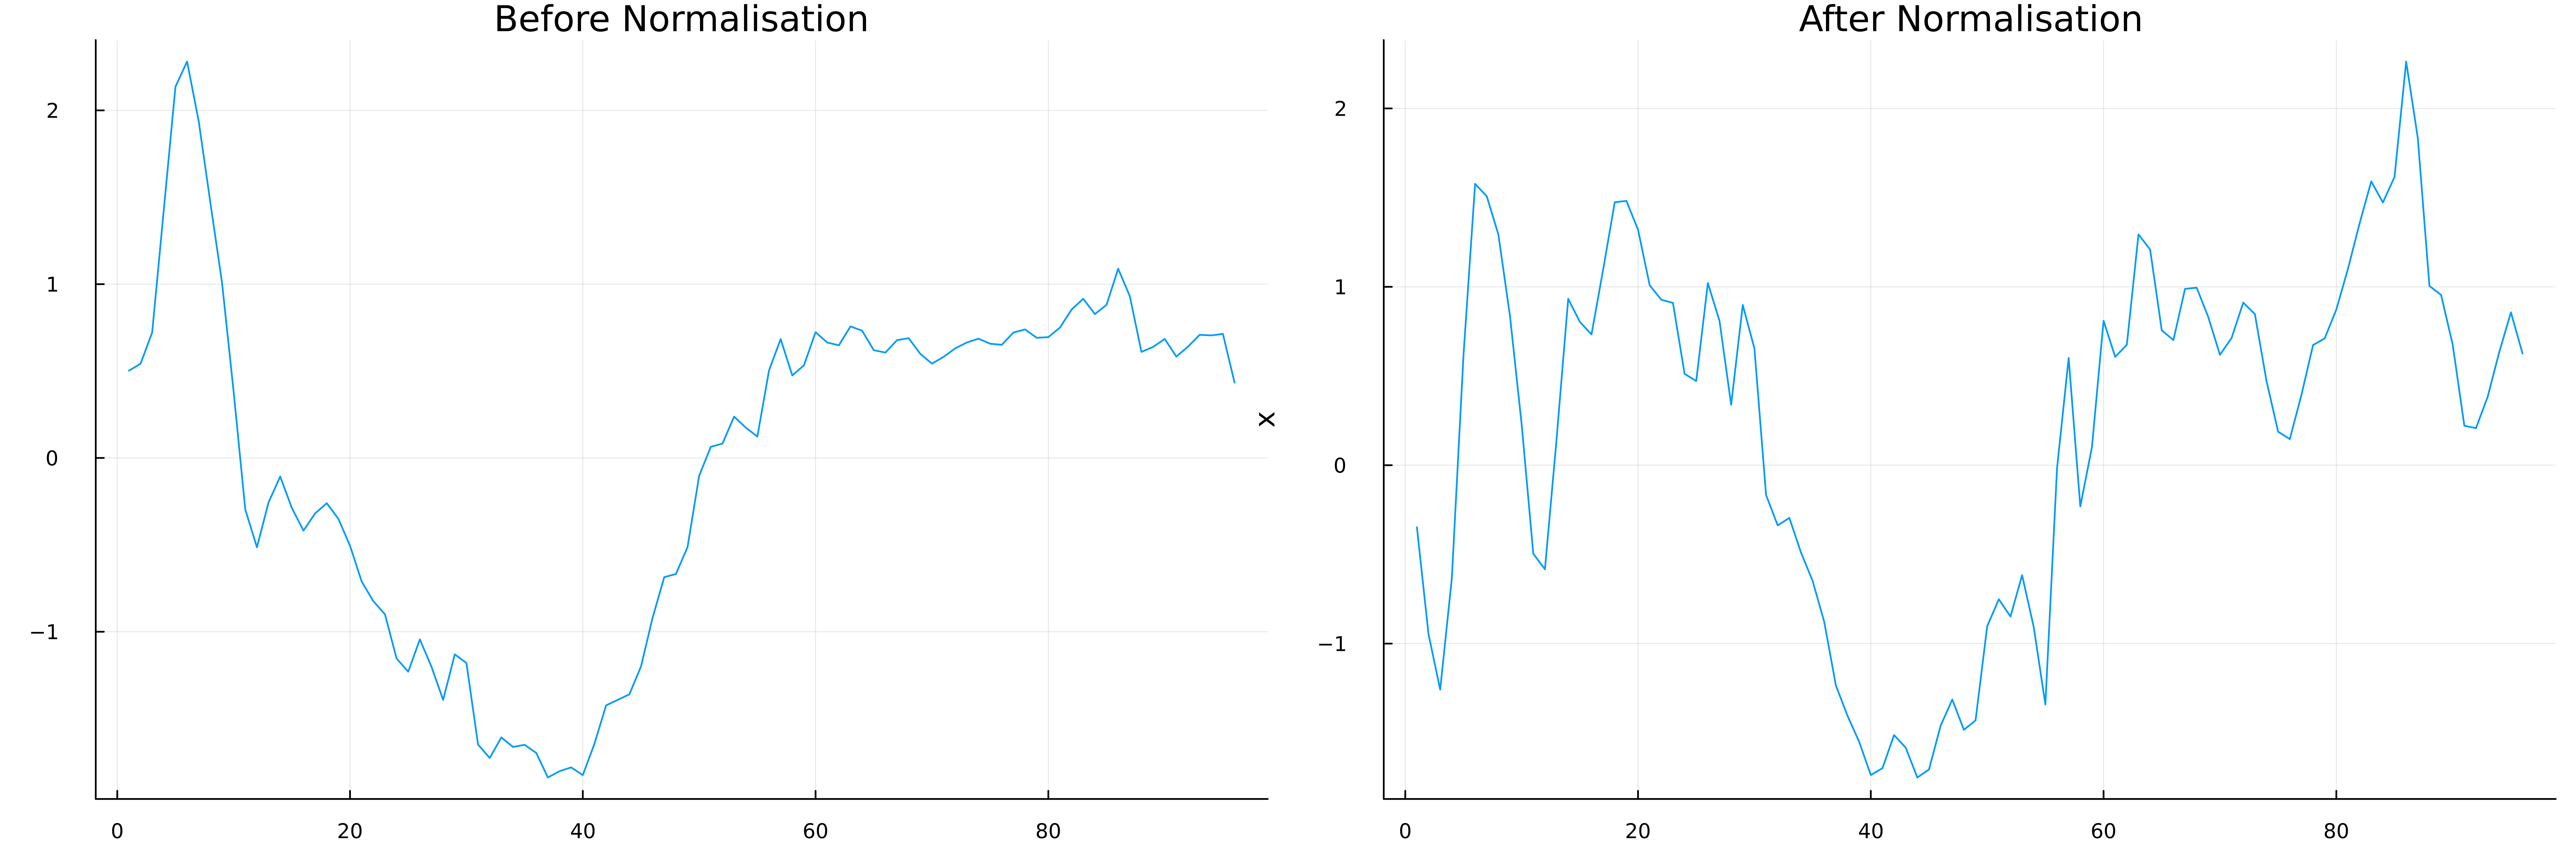

In [152]:
p1 = plot(X_train[1,:], label="", dpi=800)
title!("Before Normalisation")
xlabel!("Time")
ylabel!("x")
p2 = plot(X_train_normalised[1,:], label="")
xlabel!("Time")
ylabel!("x")
title!("After Normalisation")
plot(p1, p2, size=(1500,500))
#savefig("before_after_norm_TS.png")

Apply SaX

In [98]:
n_bins = 5
sax = pyts.SymbolicAggregateApproximation(n_bins=n_bins, strategy="normal") # strategy = gaussian bins
X_sax = sax.fit_transform(X_train_normalised);

In [99]:
X_sax.shape

(100, 96)

In [67]:
ss = pyimport("scipy.stats");
np = pyimport("numpy");

In [76]:
bins = ss.norm.ppf(np.linspace(0, 1, n_bins + 1)[2:end-1]) # compute gaussian bins

4-element Vector{Float64}:
 -0.8416212335729142
 -0.2533471031357997
  0.25334710313580006
  0.8416212335729143

In [135]:
X_sax[1]

PyObject array(['b', 'a', 'a', 'b', 'd', 'e', 'e', 'e', 'd', 'c', 'b', 'b', 'c',
       'e', 'd', 'd', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'd', 'd', 'e',
       'd', 'd', 'e', 'd', 'c', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'a',
       'b', 'a', 'a', 'c', 'd', 'c', 'c', 'd', 'd', 'd', 'e', 'e', 'd',
       'd', 'e', 'e', 'd', 'd', 'd', 'e', 'e', 'd', 'c', 'c', 'd', 'd',
       'd', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'd', 'c',
       'c', 'd', 'd', 'e', 'd'], dtype='<U1')

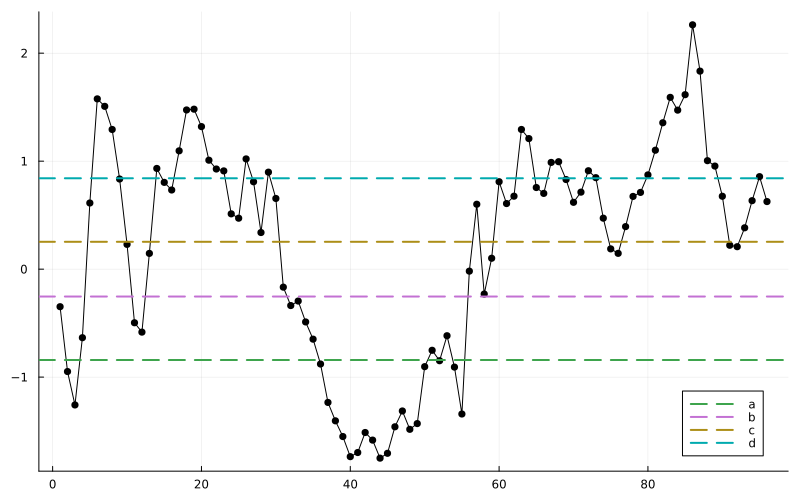

In [147]:
p = scatter(X_train_normalised[1,:], size=(800,500), label="", c=:black)
plot!(X_train_normalised[1,:], size=(800,500), label="", c=:black)
alphabet = ['a', 'b', 'c', 'd', 'e']
for i=1:4
    hline!([bins[i]], label="$(alphabet[i])", ls=:dash, lw=2)
end
display(p)

In [139]:
function SaxToEncoding(sax_sample, sites)
    mapping = Dict(
        "a" => 1,
        "b" => 2, 
        "c" => 3,
        "d" => 4,
        "e" => 5
    )
    product_state = MPS(sites; linkdims=1)
    for j=1:length(sites)
        T = ITensor(sites[j])
        letter = sax_sample[j]
        T[mapping[letter]] = 1
        product_state[j] = T
    end
    return product_state
end;

In [140]:
SaxToEncoding(X_sax[1], sites)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\smoor\.julia\packages\PyCall\1gn3u\src\PyCall.jl:783 =# @pysym(:PyObject_GetItem), PyPtr, (PyPtr, PyPtr), o, PyObject(k)))))) <class 'IndexError'>
IndexError('index 96 is out of bounds for axis 0 with size 96')
